# Training Set & Validation Set


In [ ]:
from pathlib import Path
from keras.preprocessing import image
from keras.applications import Xception, xception, InceptionV3, inception_v3, InceptionResNetV2, inception_resnet_v2, NASNetLarge, nasnet

import numpy as np
import pandas as pd
import tensorflow as tf
import keras.backend.tensorflow_backend as KTF

KTF.set_session(tf.Session(config=tf.ConfigProto(device_count={'gpu':0})))

import os
import seaborn as sns
import matplotlib.pyplot as plt

%matplotlib inline

FOLDER_TRN = Path('train/')
FOLDER_TEST = Path('test/')

In [5]:
df = pd.read_csv('data_clean.csv')
df.head()

,file,label
0,cat.2960.jpg,cat
1,dog.11107.jpg,dog
2,cat.3056.jpg,cat
3,cat.12279.jpg,cat
4,dog.7786.jpg,dog


In [10]:
from sklearn.model_selection import train_test_split


# Dataframe of training set & validation set
df_trn, df_val = train_test_split(df, stratify=df['label'], random_state=0)
df_trn.reset_index(drop=True, inplace=True)
df_val.reset_index(drop=True, inplace=True)

In [11]:
def show_images_from_df(data_df, nrows, ncols, directory=FOLDER_TRN, is_train=True, pred_label=None):
    """
        showing images from dataframe.
    """
    
    fig, ax = plt.subplots(nrows, ncols, figsize=(15, 15))
    plt.subplots_adjust(wspace=.4, hspace=.5)
    
    for idx, row in data_df[:nrows*ncols].iterrows():
        fname = row['file']
        prob = pred_label[idx] if not is_train else 1.000
        label = row['label'] if is_train  else ('dog' if prob > 0.500 else 'cat')
        img = plt.imread(os.path.join(directory, fname))
        
        ax[idx // ncols, idx % ncols].imshow(img)
        if is_train:
            ax[idx // ncols, idx % ncols].set_title("file: {}\n label: {}".format(fname, label), size=12)
        else:
            ax[idx // ncols, idx % ncols].set_title("file: {}\n prediction: {}\nprobability:{:.3f}".format(fname, label, prob), size=12)

        ax[idx // ncols, idx % ncols].get_xaxis().set_visible(False)
        ax[idx // ncols, idx % ncols].get_yaxis().set_visible(False)

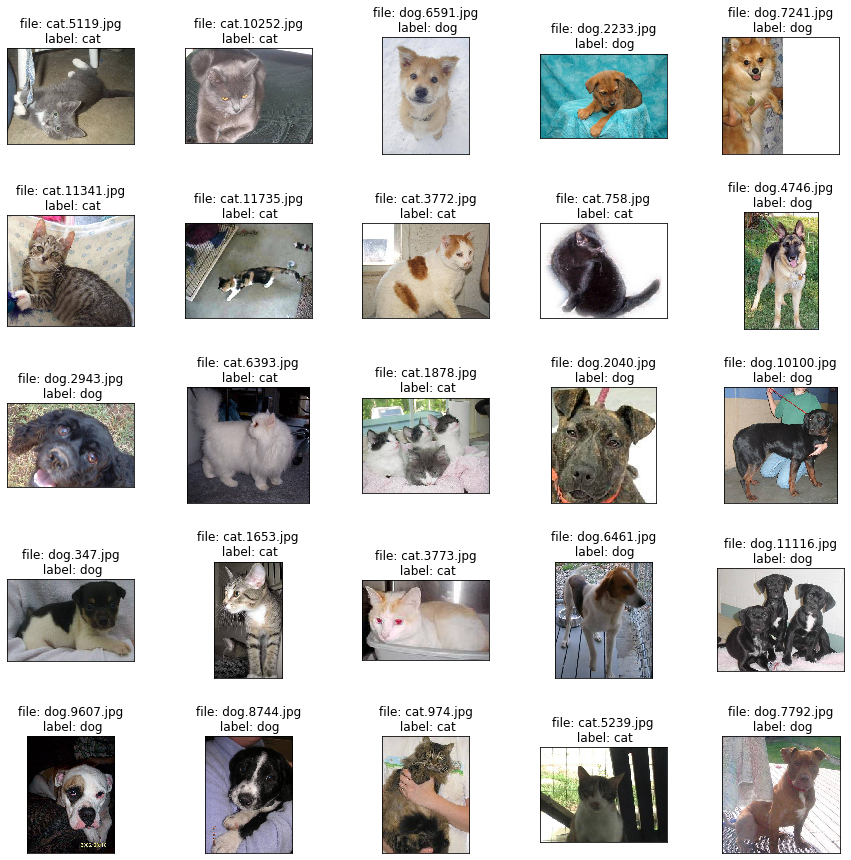

In [30]:
# Show images of training data
show_images_from_df(df_trn, 5, 5)

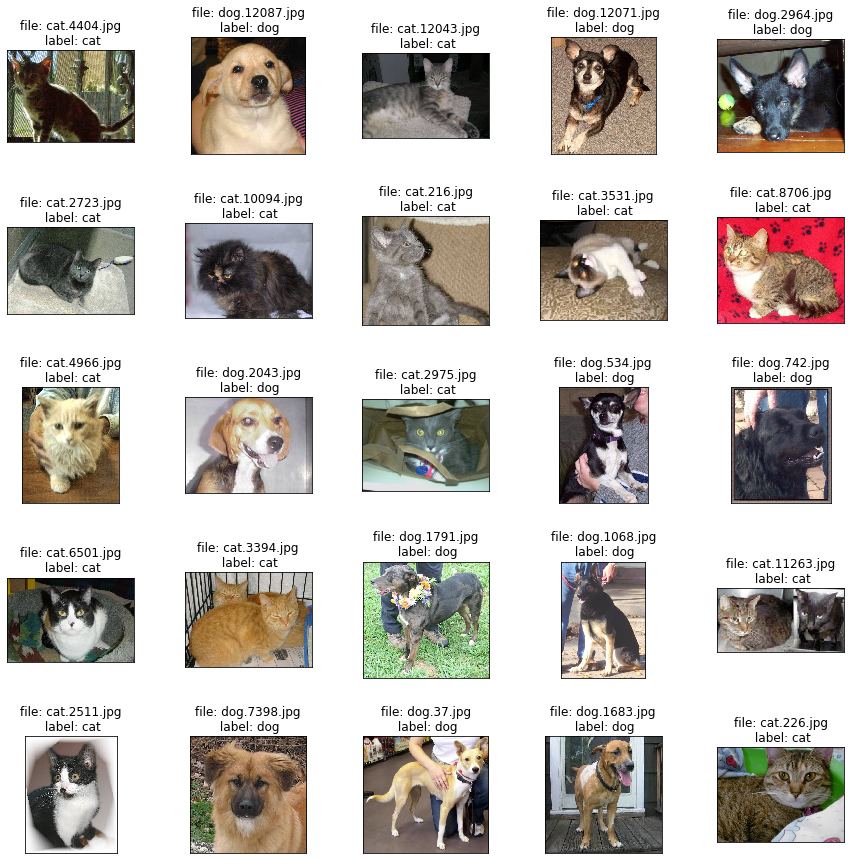

In [31]:
# Show images of validation data
show_images_from_df(df_val, 5, 5)

# Data Augmentation

In [12]:
from keras.preprocessing.image import ImageDataGenerator


# Batch size
BATCH_SIZE_331 = 16
BATCH_SIZE_299 = 32

# Image size
SIZE_299 = (299, 299)
SIZE_331 = (331, 331)

def generator_flow(
    datagen, df, target_size, batch_size,
    directory=FOLDER_TRN, x_col='file', y_col='label',
    mode='binary', shuffle=True
):
    gen = datagen.flow_from_dataframe(
        df, 
        directory=directory, 
        x_col=x_col,
        y_col=y_col, 
        target_size=target_size, 
        class_mode=mode,
        batch_size=batch_size,
        shuffle=shuffle
    )
    return gen

datagen_trn = ImageDataGenerator(
    rotation_range=25,
    
    width_shift_range=.1,
    height_shift_range=.1,
    zoom_range=.2,
    shear_range=.1,
    horizontal_flip=True
)
datagen_val = ImageDataGenerator()

In [13]:
# Data generator of training data & validation data with different size
generator_trn_331 = generator_flow(datagen_trn, df_trn, SIZE_331, BATCH_SIZE_331)
generator_val_331 = generator_flow(datagen_val, df_val, SIZE_331, BATCH_SIZE_331)
generator_trn_299 = generator_flow(datagen_trn, df_trn, SIZE_299, BATCH_SIZE_299)
generator_val_299 = generator_flow(datagen_val, df_val, SIZE_299, BATCH_SIZE_299)

Found 18429 images belonging to 2 classes.
Found 6143 images belonging to 2 classes.
Found 18429 images belonging to 2 classes.
Found 6143 images belonging to 2 classes.


In [83]:
# Class indices
print(generator_trn_331.class_indices)
print(generator_trn_299.class_indices)
print(generator_val_331.class_indices)
print(generator_val_299.class_indices)

{'cat': 0, 'dog': 1}
{'cat': 0, 'dog': 1}
{'cat': 0, 'dog': 1}
{'cat': 0, 'dog': 1}


In [14]:
# define a function for sorting the testing images in their directory by number in image name
import re


def key_func(entry):
    """
        sort files in their directory by number of its name.
    """
    return int(re.search(r'\d+', entry).group())

In [15]:
# Sort testing data
fnames_tst = os.listdir(FOLDER_TEST)
fnames_tst.sort(key=key_func)
fnames_tst[:10]

['1.jpg',
 '2.jpg',
 '3.jpg',
 '4.jpg',
 '5.jpg',
 '6.jpg',
 '7.jpg',
 '8.jpg',
 '9.jpg',
 '10.jpg']

In [16]:
# Generator for testing data, set 'shuffle'=False
df_tst = pd.DataFrame({
    'file': fnames_tst
})
datagen_tst = ImageDataGenerator()
generator_tst_331 = generator_flow(datagen_tst, df_tst, (331, 331), 16, directory=FOLDER_TEST, y_col=None, mode=None, shuffle=False)
generator_tst_299 = generator_flow(datagen_tst, df_tst, SIZE_299, BATCH_SIZE_299, directory=FOLDER_TEST, y_col=None, mode=None, shuffle=False)

Found 12500 images.
Found 12500 images.


# ***********************

# Transfer Learning
# Pretrained Xception, InceptionV3, NASNetLarge & InceptionResNetV2
# Model Building

# ***********************

In [17]:
from keras.models import Model
from keras.layers import Input, Lambda


SHAPE_299 = (299, 299, 3)
SHAPE_331 = (331, 331, 3)


def build_pretrained_model(base_model, input_shape, preprocess_func, weight_scheme='imagenet', trainable=False):
    """
        pretrained model, remove top level, preprocess inputs, for extrating features.
    """
    model_input = Input(shape=input_shape) 
    tensor = Lambda(preprocess_func)(model_input)
    pretrained_model = base_model(input_tensor=tensor, weights=weight_scheme, include_top=False, pooling='avg')
    model = Model(model_input, pretrained_model.output)
    model.trainable = trainable
    
    return model

In [18]:
# Build pretrained Xception & InceptionV3 model with input shape (299, 299, 3) 
model_xception = build_pretrained_model(Xception, SHAPE_299, xception.preprocess_input)
model_inceptionv3 = build_pretrained_model(InceptionV3, SHAPE_299, inception_v3.preprocess_input)

# Build pretrained NASNetLarge & InceptionResNetV2 model with input shape (331, 331, 3) 
model_nasnet = build_pretrained_model(NASNetLarge, SHAPE_331, nasnet.preprocess_input)
model_inception_resnet = build_pretrained_model(InceptionResNetV2, SHAPE_331, inception_resnet_v2.preprocess_input)

Instructions for updating:
Colocations handled automatically by placer.


In [19]:
from keras.layers import Concatenate, Dense, Dropout, Flatten, BatchNormalization, Activation


def build_model(pretrained_models, input_shape):
    """
        build model with features extracted by pretained models, for predicting testing data.
    """
    model_input = Input(shape=input_shape)
    extracted_features = [pm(model_input) for pm in pretrained_models]

    x = Concatenate()(extracted_features)
    x = Dropout(rate=.5, name='dropout')(x)
    
    if x.shape[-1] == 4096:
        x = Dense(1024, name='dense1')(x)
        x = BatchNormalization()(x)
        x = Activation('relu')(x)
        x = Dropout(rate=.5, name='drop1')(x)
        x = Dense(16, name='dense2')(x)
        x = Activation('relu')(x)
        x = Dropout(rate=.3, name='drop2')(x)

    else:
        x = Dense(128, name='dense1')(x)
        x = BatchNormalization()(x)
        x = Activation('relu')(x)
        x = Dropout(rate=.3, name='drop1')(x)
    
    prob = Dense(1, activation='sigmoid', name='prob')(x)
    model = Model(inputs=model_input, outputs=prob)
    
    return model

In [20]:
# Build model with input shape (299, 299, 3)
model_299 = build_model([model_xception, model_inceptionv3], SHAPE_299)
# Build model with input shape (331, 331, 3)
model_331 = build_model([model_nasnet, model_inception_resnet], SHAPE_331)

Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


In [80]:
# Summary of Model with input shape (299, 299, 3)
model_299.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_10 (InputLayer)           (None, 299, 299, 3)  0                                            
__________________________________________________________________________________________________
model_8 (Model)                 (None, 2048)         20861480    input_10[0][0]                   
__________________________________________________________________________________________________
model_9 (Model)                 (None, 2048)         21802784    input_10[0][0]                   
__________________________________________________________________________________________________
concatenate_10 (Concatenate)    (None, 4096)         0           model_8[1][0]                    
                                                                 model_9[1][0]                    
__________

In [68]:
# Summary of Model with input shape (224, 224, 3)
model_331.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_8 (InputLayer)            (None, 331, 331, 3)  0                                            
__________________________________________________________________________________________________
model_1 (Model)                 (None, 4032)         84916818    input_8[0][0]                    
__________________________________________________________________________________________________
model_2 (Model)                 (None, 1536)         54336736    input_8[0][0]                    
__________________________________________________________________________________________________
concatenate_12 (Concatenate)    (None, 5568)         0           model_1[4][0]                    
                                                                 model_2[4][0]                    
__________

# Model Visualization

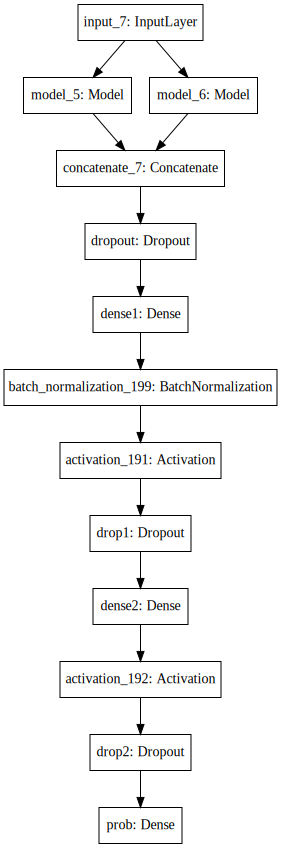

In [41]:
# Show the model graphical representation
from IPython.display import SVG
from keras.utils import plot_model
from keras.utils.vis_utils import model_to_dot


GRAPHFILE='model299.png'
plot_model(model_299, to_file=GRAPHFILE)
SVG(model_to_dot(model_299).create(prog='dot', format='svg'))

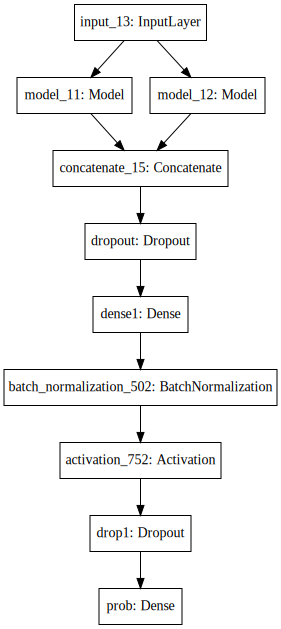

In [86]:
GRAPHFILE='model331.png'
plot_model(model_331, to_file=GRAPHFILE)
SVG(model_to_dot(model_331).create(prog='dot', format='svg'))

# Model training

In [21]:
from keras.optimizers import SGD


# Model compiling
model_299.compile(loss='binary_crossentropy', metrics=['accuracy'], optimizer=SGD(momentum=.9, decay=1e-3, nesterov=True))
model_331.compile(loss='binary_crossentropy', metrics=['accuracy'], optimizer=SGD(momentum=.9, decay=1e-3, nesterov=True))

In [22]:
from keras.callbacks import ModelCheckpoint, EarlyStopping

import gc


# Traininig epochs
EPOCHS = 10

# Files storing model best weights
WEIGHTFILE299 = 'model299.weights.best.hdf5'
WEIGHTFILE331 = 'model331.weights.best.hdf5'

# Model check point
ckp299 = ModelCheckpoint(
    filepath=WEIGHTFILE299,
    save_best_only=True,
    verbose=1
)

ckp331 = ModelCheckpoint(
    filepath=WEIGHTFILE331,
    save_best_only=True,
    verbose=1
)

# Early stopping
es = EarlyStopping(patience=3, verbose=1)

In [59]:
# Garbage collection
gc.collect()

# Model traininig with image input shape=(299, 299, 3)
history_299 = model_299.fit_generator(
    generator_trn_299, 
    steps_per_epoch=len(df_trn) // BATCH_SIZE_299,
    epochs=EPOCHS,
    callbacks=[ckp299, es],
    validation_data=generator_val_299,
    validation_steps=len(df_val) // BATCH_SIZE_299,
    verbose=1
)

Epoch 1/10
575/575 [==============================] - 700s 1s/step - loss: 0.1087 - acc: 0.9682 - val_loss: 0.0674 - val_acc: 0.9910

Epoch 00001: val_loss improved from inf to 0.06740, saving model to model299.0823.1218.weights.best.hdf5
Epoch 2/10
575/575 [==============================] - 673s 1s/step - loss: 0.0840 - acc: 0.9773 - val_loss: 0.0154 - val_acc: 0.9974

Epoch 00002: val_loss improved from 0.06740 to 0.01544, saving model to model299.0823.1218.weights.best.hdf5
Epoch 3/10
575/575 [==============================] - 674s 1s/step - loss: 0.0736 - acc: 0.9793 - val_loss: 0.0225 - val_acc: 0.9967

Epoch 00003: val_loss did not improve from 0.01544
Epoch 4/10
575/575 [==============================] - 674s 1s/step - loss: 0.0742 - acc: 0.9808 - val_loss: 0.0395 - val_acc: 0.9943

Epoch 00004: val_loss did not improve from 0.01544
Epoch 5/10
575/575 [==============================] - 674s 1s/step - loss: 0.0709 - acc: 0.9812 - val_loss: 0.0113 - val_acc: 0.9977

Epoch 00005: v

In [61]:
# Load the best weight gained from traninig
model_299.load_weights(WEIGHTFILE299)

In [24]:
# Garbage collection
gc.collect()

# Model traininig with image input shape=(331, 331, 3)
history_331 = model_331.fit_generator(
    generator_trn_331, 
    steps_per_epoch=len(df_trn) // BATCH_SIZE_331,
    epochs=EPOCHS,
    callbacks=[ckp331, es],
    validation_data=generator_val_331,
    validation_steps=len(df_val) // BATCH_SIZE_331,
    verbose=1
)

Instructions for updating:
Use tf.cast instead.
Epoch 1/10
1151/1151 [==============================] - 2624s 2s/step - loss: 0.0429 - acc: 0.9851 - val_loss: 0.0222 - val_acc: 0.9930

Epoch 00001: val_loss improved from inf to 0.02225, saving model to model331.weights.best.hdf5
Epoch 2/10
1151/1151 [==============================] - 2585s 2s/step - loss: 0.0409 - acc: 0.9848 - val_loss: 0.0191 - val_acc: 0.9936

Epoch 00002: val_loss improved from 0.02225 to 0.01910, saving model to model331.weights.best.hdf5
Epoch 3/10
1151/1151 [==============================] - 2582s 2s/step - loss: 0.0377 - acc: 0.9854 - val_loss: 0.0208 - val_acc: 0.9938

Epoch 00003: val_loss did not improve from 0.01910
Epoch 4/10
1151/1151 [==============================] - 2580s 2s/step - loss: 0.0359 - acc: 0.9862 - val_loss: 0.0227 - val_acc: 0.9925

Epoch 00004: val_loss did not improve from 0.01910
Epoch 5/10
1151/1151 [==============================] - 2581s 2s/step - loss: 0.0399 - acc: 0.9861 - val_los

In [25]:
# Load the best weight gained from traninig
model_331.load_weights(WEIGHTFILE331)

# Training History Visualization

In [26]:
# Visualization of accuracy&loss for training step&validation step
def view_acc_and_loss(his):
    fig, axes = plt.subplots(1, 2, figsize=(18,5))

    for i, c in enumerate(['acc', 'loss']):
        axes[i].plot(his[c], label=f'Training {c}')
        axes[i].plot(his[f'val_{c}'], label=f'Validation {c}')
        axes[i].set_xlabel('epoch')
        axes[i].set_ylabel(c);
        axes[i].legend()
        axes[i].set_title(f'Training and Validation {c}')
        plt.grid()
    
    plt.show()

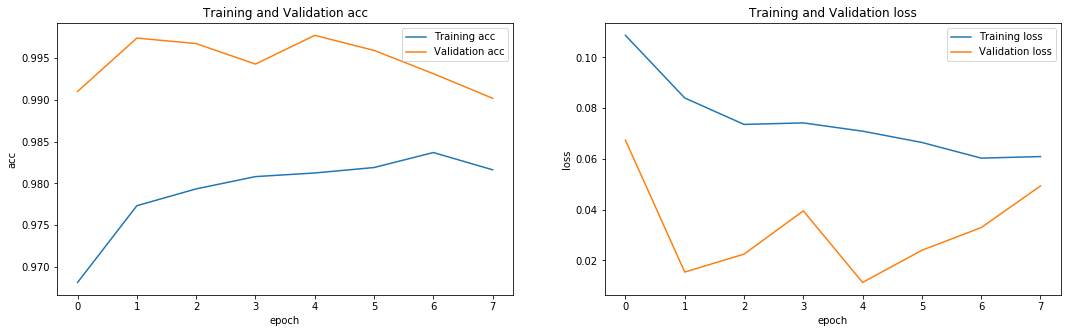

In [60]:
# Plotting loss and accuracy for model_299
view_acc_and_loss(history_299.history)

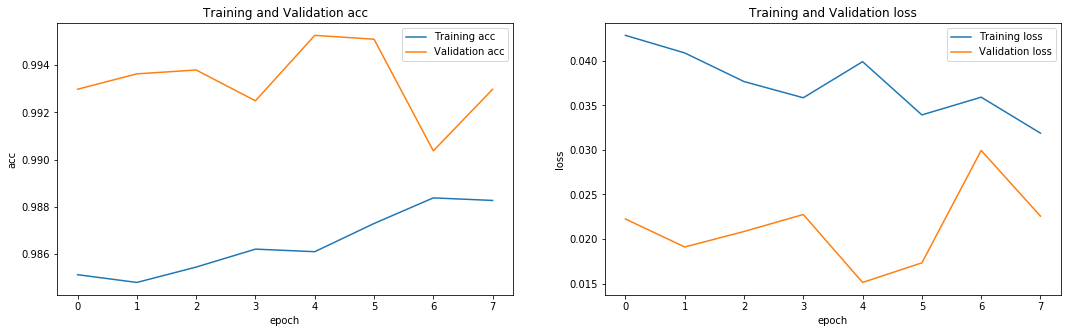

In [27]:
# Plotting loss and accuracy for model_331(SGD with lr=9e-3)
view_acc_and_loss(history_331.history)

# Model Prediction

In [78]:
# Model_299 prediction
pred_299 = model_299.predict_generator(generator_tst_299, steps=np.ceil(len(df_tst) / BATCH_SIZE_299))
# Clip into range (0.005, 0.995), and reduce to 1 dimension
prob_299 = pred_299.clip(min=0.005, max=0.995).ravel()

In [28]:
# Model_331 prediction
pred_331 = model_331.predict_generator(generator_tst_331, steps=np.ceil(len(df_tst) / BATCH_SIZE_331))
# Clip into range (0.005, 0.995), and reduce to 1 dimension
prob_331 = pred_331.clip(min=0.005, max=0.995).ravel()

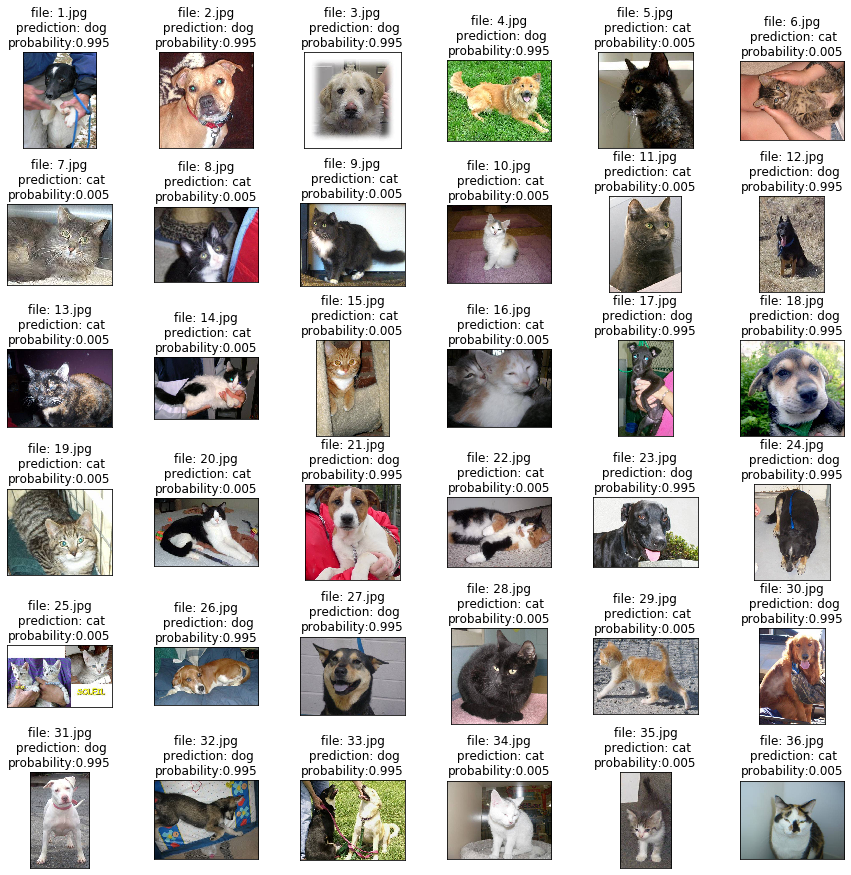

In [65]:
# Performance on testing set by model_299
show_images_from_df(df_tst, 6, 6, directory='test/', is_train=False, pred_label=prob_299)

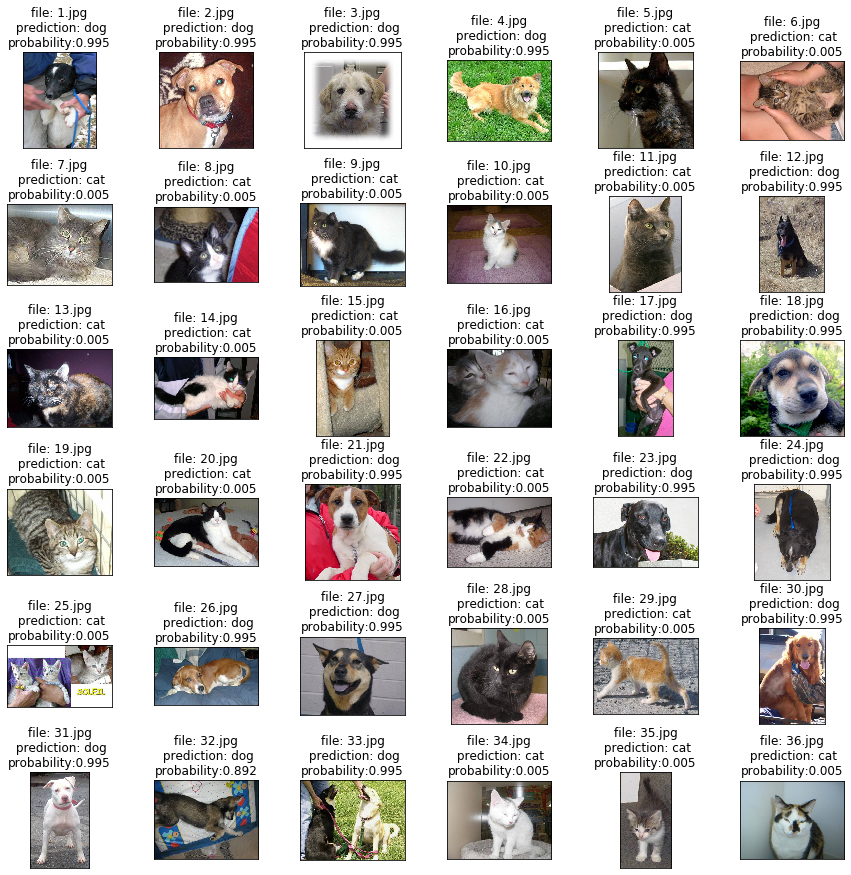

In [29]:
# Performance on testing set by model_331
show_images_from_df(df_tst, 6, 6, directory=FOLDER_TEST, is_train=False, pred_label=prob_331)

# Final Result

In [79]:
# Generate submission file for model_299
submission_df = pd.read_csv('sample_submission.csv')
for idx, fname in enumerate(fnames_tst):
    idx_df = int(fname.split('.')[0]) - 1
    submission_df.at[idx_df, 'label'] = prob_299[idx]

SUBMITFILE_299 = 'submission_299.csv'
submission_df.to_csv(SUBMITFILE_299, index=False)
submission_df.head()

,id,label
0,1,0.995
1,2,0.995
2,3,0.995
3,4,0.995
4,5,0.005


In [30]:
# Generate submission file fof model_331
submission_df = pd.read_csv('sample_submission.csv')
for idx, fname in enumerate(fnames_tst):
    idx_df = int(fname.split('.')[0]) - 1
    submission_df.at[idx_df, 'label'] = prob_331[idx]

SUBMITFILE_331= 'submission_331.csv'
submission_df.to_csv(SUBMITFILE_331, index=False)
submission_df.head()

,id,label
0,1,0.995
1,2,0.995
2,3,0.995
3,4,0.995
4,5,0.005
